# 1. Importing libraries

In [64]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from natsort import natsorted 
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
import urllib.request
import urllib
import tarfile
import pickle
from skimage import measure

# 2. Dataset

## 2.1. Download

In [65]:
# def download_and_extract_oxford_pet_dataset(destination_folder):
#     """
#     Baixa e extrai o Oxford-IIIT Pet Dataset (imagens e anotações).
    
#     :param destination_folder: Caminho do diretório onde os arquivos serão salvos e extraídos.
#     """
#     # URLs dos arquivos
#     urls = {
#         "images": "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz",
#         "annotations": "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
#     }
    
#     # Criar a pasta de destino, se não existir
#     os.makedirs(destination_folder, exist_ok=True)
    
#     for key, url in urls.items():
#         print(f"Baixando {key}...")
#         file_name = os.path.join(destination_folder, url.split("/")[-1])
        
#         # Fazer o download do arquivo
#         urllib.request.urlretrieve(url, file_name)
#         print(f"Download concluído: {file_name}")
        
#         # Extrair o arquivo tar.gz
#         print(f"Extraindo {key}...")
#         with tarfile.open(file_name, "r:gz") as tar:
#             tar.extractall(path=destination_folder)
#         print(f"Extração concluída para {key}.\n")

#         # Remover o arquivo compactado para economizar espaço
#         os.remove(file_name)
#         print(f"Arquivo compactado {file_name} removido.")

# # Exemplo de uso
# destination_folder = "./oxford_pet_dataset"  # Caminho onde o dataset será salvo
# download_and_extract_oxford_pet_dataset(destination_folder)

## 2.2. Definition

### Standard Data

Resizing original images and segmented images to 300x300 and transforming into NumpyArray:

In [66]:
def load_and_resize_images(folder_path, target_size=(300, 300), mode=None):
    """
    Carrega imagens de uma pasta, redimensiona para um tamanho fixo e transforma em um array NumPy.
    
    :param folder_path: Caminho para a pasta contendo as imagens.
    :param target_size: Tamanho fixo (largura, altura) para redimensionar as imagens.
    :param mode: 0 se imagens, 1 se trimaps
    :return: Array NumPy com todas as imagens redimensionadas.
    """

    file_names = natsorted(os.listdir(folder_path))

    image_arrays = []
    for filename in file_names:
        file_path = os.path.join(folder_path, filename)
        try:
            if mode == 0:
                with Image.open(file_path) as img:
                    img_resized = img.resize(target_size)  # redimensiona para 300x300
                    img_array = np.array(img_resized)     # converte para array NumPy
                    
                    if len(img_array.shape) == 2:
                        img_array = np.stack([img_array] * 3, axis=-1)
                    
                    image_arrays.append(img_array)
            
            elif mode ==1:
                with Image.open(file_path) as img:
                    img = img.convert("L")  
                    
                    img_resized = img.resize(target_size, resample=Image.NEAREST)
                    
                    trimap_array = np.array(img_resized)
                    
                    image_arrays.append(trimap_array)
            else:
                print(f"Mode not suported.")

        except Exception as e:
            print(f"Erro ao processar {filename}: {e}")
    
    images_array = np.stack(image_arrays, axis=0)
    return images_array

In [67]:
folder_path = "./oxford_pet_dataset/images/"
data = load_and_resize_images(folder_path, mode=0)

folder_path = "./oxford_pet_dataset/annotations/trimaps/"
data_tri_segmented = load_and_resize_images(folder_path, mode=1)

print(f"Shape do array data gerado: {data.shape}")
print(f"Shape do array segmented gerado: {data_tri_segmented.shape}")

Shape do array data gerado: (26, 300, 300, 3)
Shape do array segmented gerado: (26, 300, 300)


Viewing sample images and segmentations:

In [68]:
def visualize_segmented_image(data, data_segmented, num_images):
    """
    Exibe uma imagem e sua segmentação lado a lado.
    
    :param data: Array de imagens do Oxford-IIIT Pet Dataset.
    :param data_semented: Array de segmentações.
    :param num_images: número de imagens a serem exibidas
    """

    for i in range(num_images):
        plt.figure(figsize=(12, 6))
        
        # imagem original
        plt.subplot(1, 2, 1)
        plt.imshow(data[i])
        plt.title("Imagem Original")
        plt.axis("off")
        
        # segmentada
        plt.subplot(1, 2, 2)
        plt.imshow(data_segmented[i], cmap='gray')
        plt.title("Segmentação (Trimap)")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()

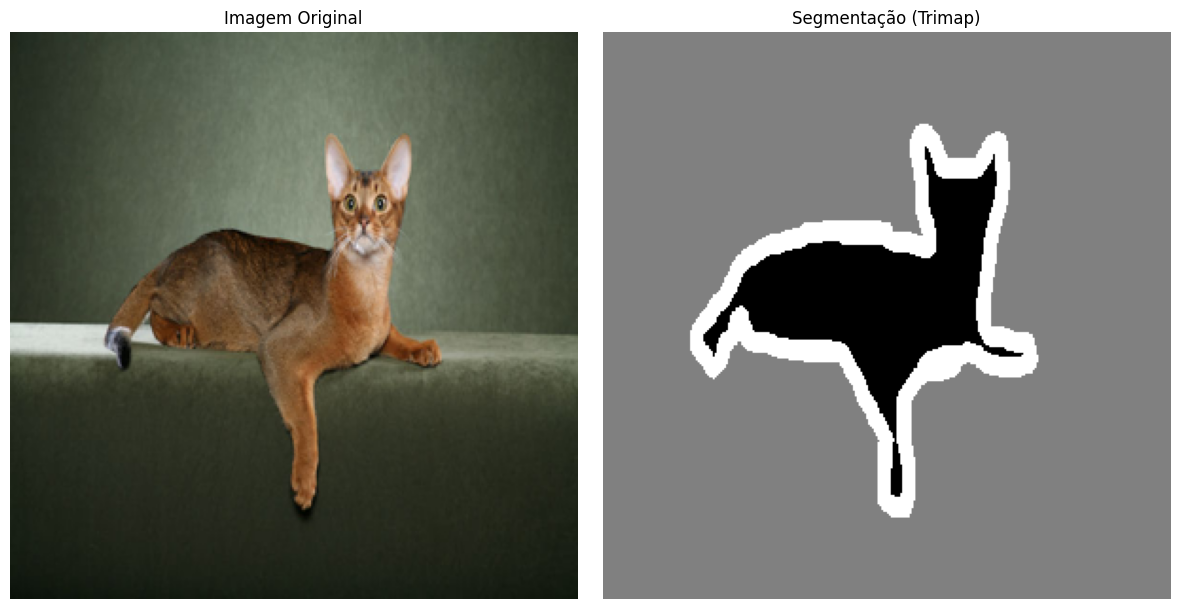

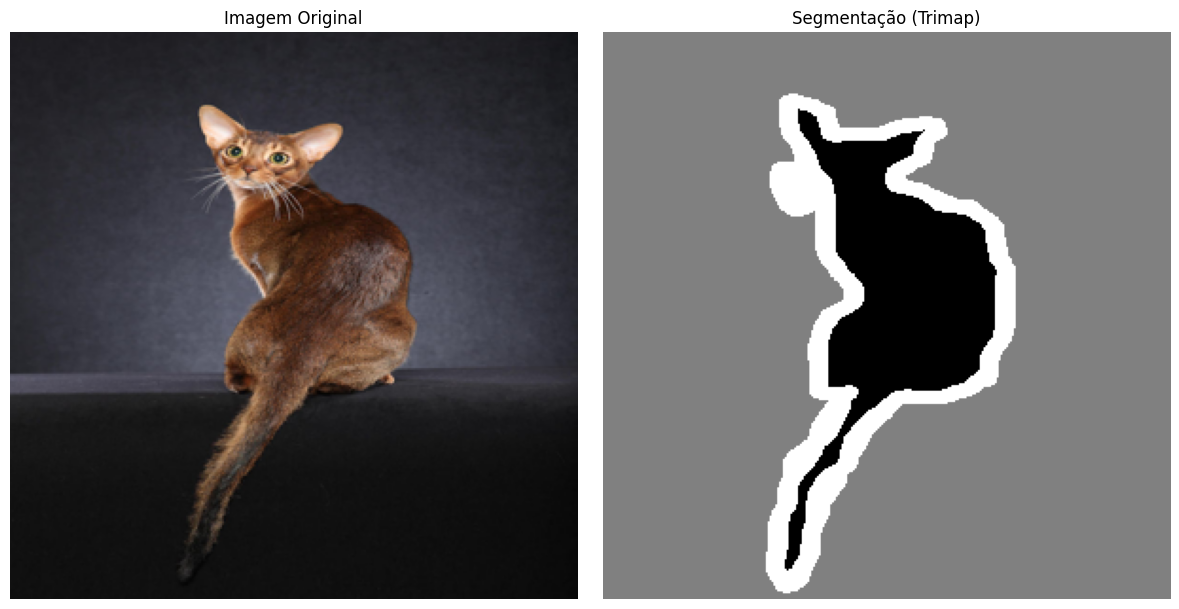

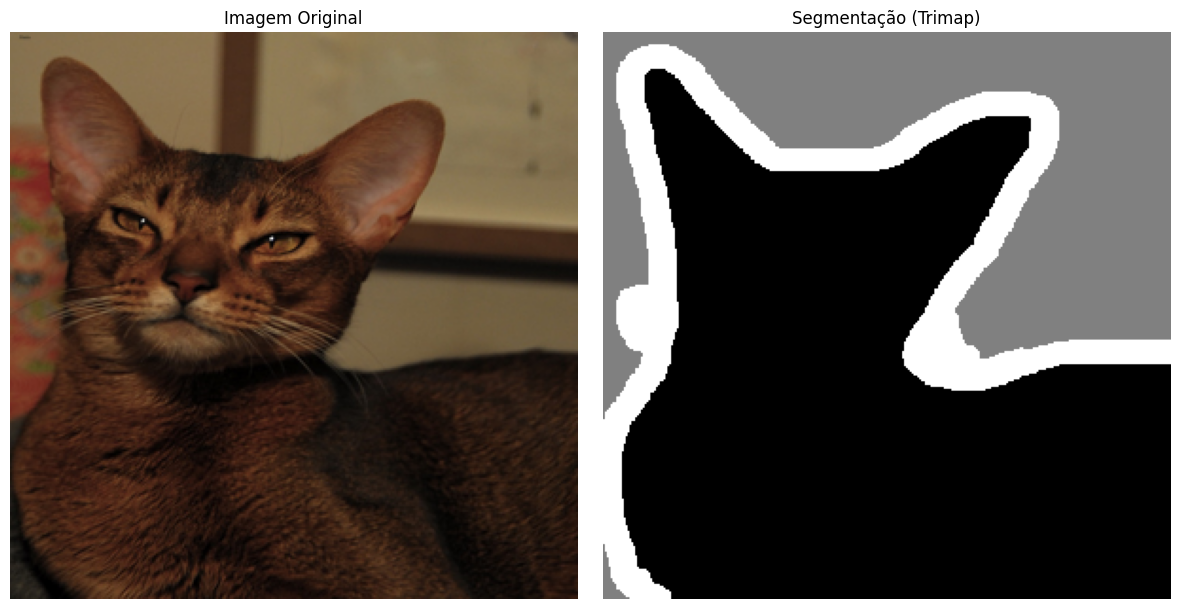

In [69]:
visualize_segmented_image(data,data_tri_segmented, num_images=3)

Combinando segmentação para deixar apenas objeto (gato) e fundo:

In [70]:
def combine_classes(data_seg):
    """
    Combina as classes 1 e 2 em uma única classe (1) e deixa o fundo como 0.
    
    :param annotation_path: Caminho para o arquivo de segmentação (trimap).
    :return: Array NumPy com a segmentação ajustada.
    """
    binary_annotation = []
    
    for img_seg in data_seg:
        binary_annotation.append(np.where(img_seg == 2, 0, 1))
    
    images_array = np.stack(binary_annotation, axis=0)

    return images_array


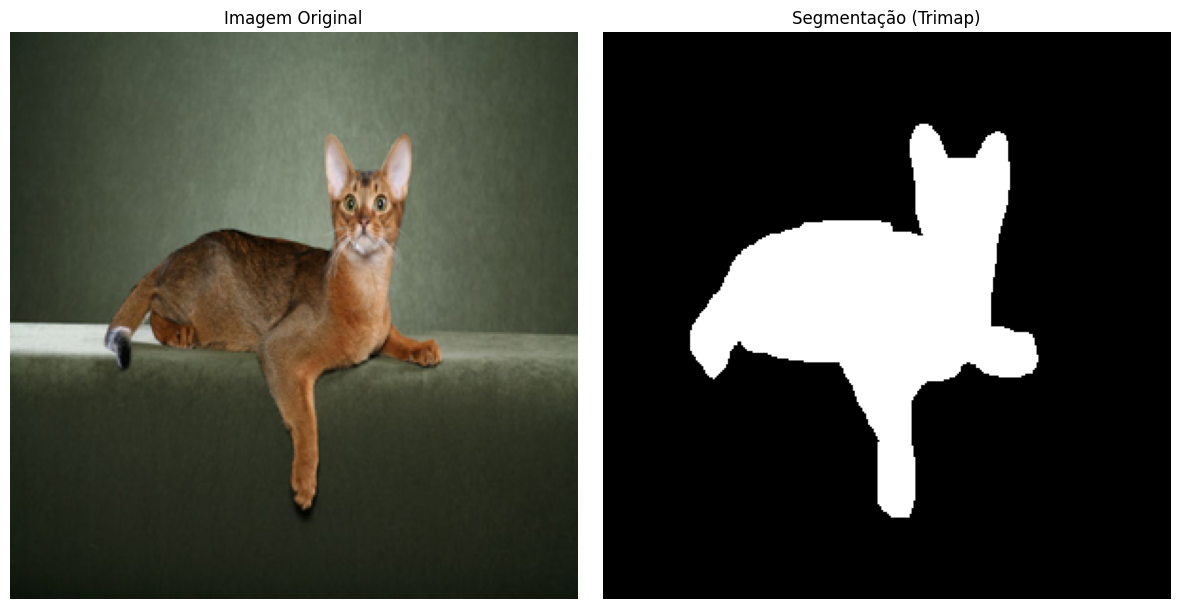

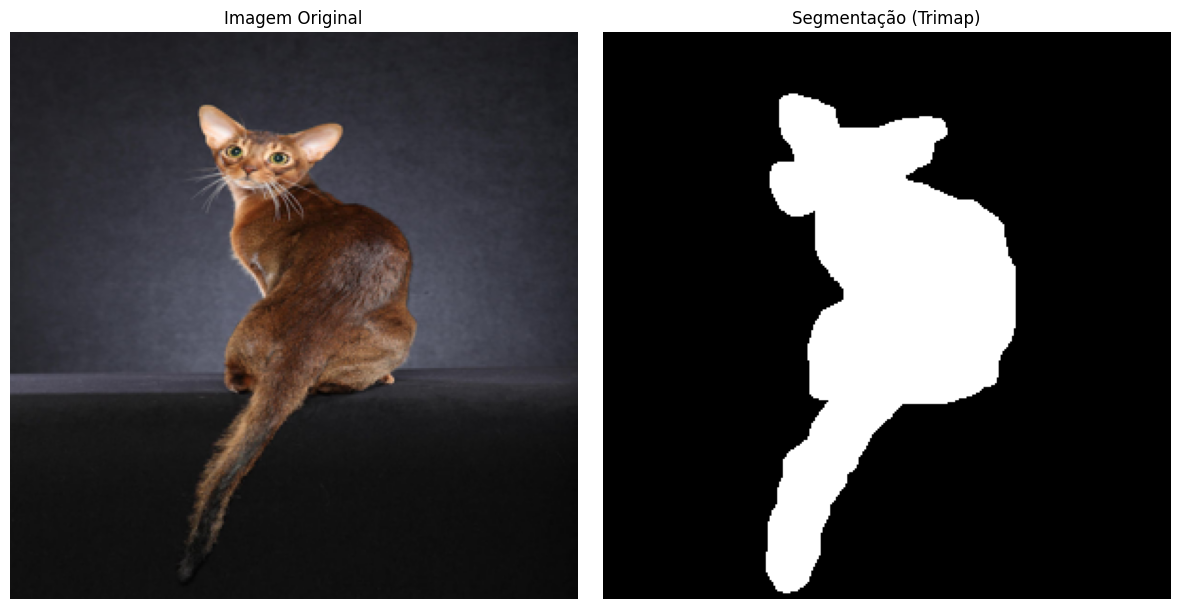

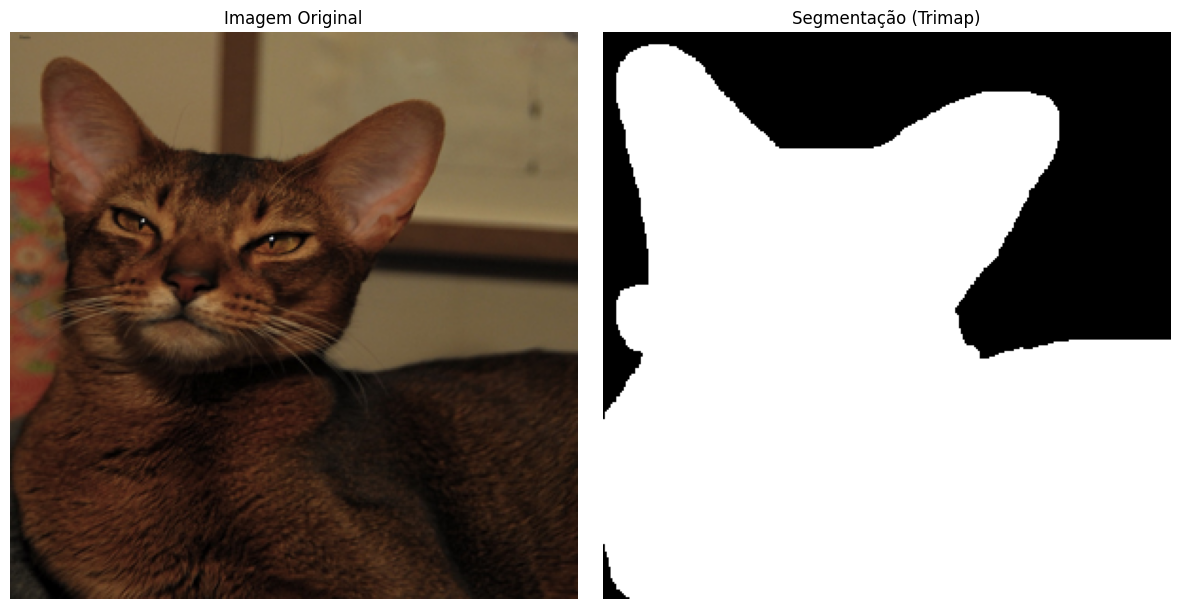

In [71]:
data_segmented = combine_classes(data_tri_segmented)

visualize_segmented_image(data,data_segmented,3)

### Data Redimensioned

In [72]:
output_size = (100,100)

folder_path = "./oxford_pet_dataset/images/"
redimensioned_data = load_and_resize_images(folder_path, mode=0, target_size = output_size)

folder_path = "./oxford_pet_dataset/annotations/trimaps/"
redimensioned_data_tri_segmented = load_and_resize_images(folder_path, mode=1, target_size =  output_size)
redimensioned_segmentation = combine_classes(redimensioned_data_tri_segmented)

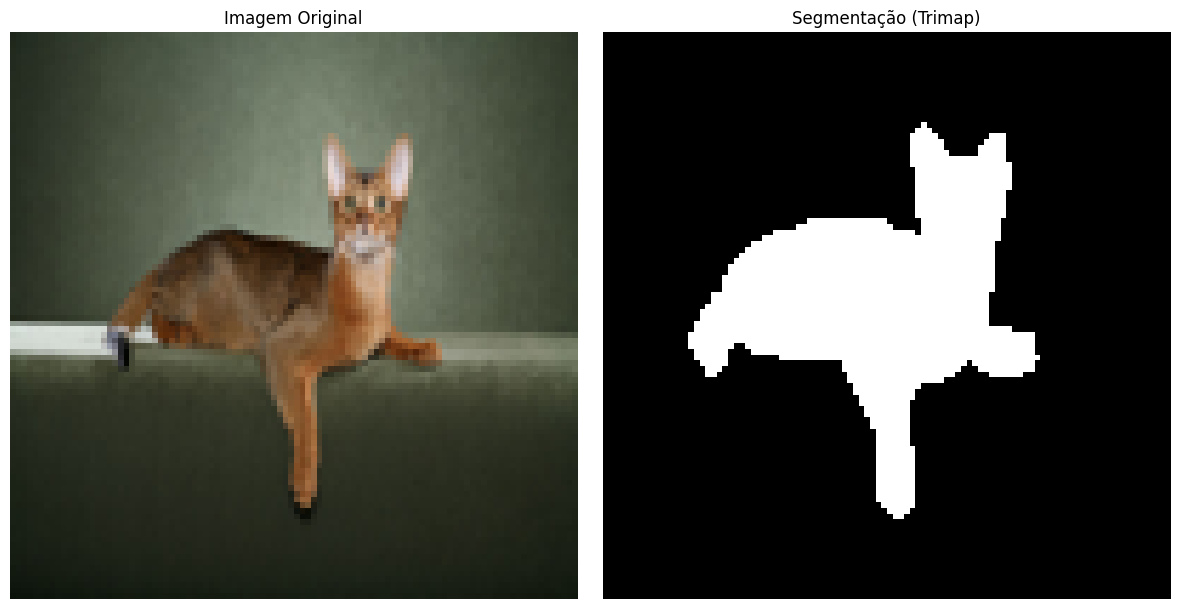

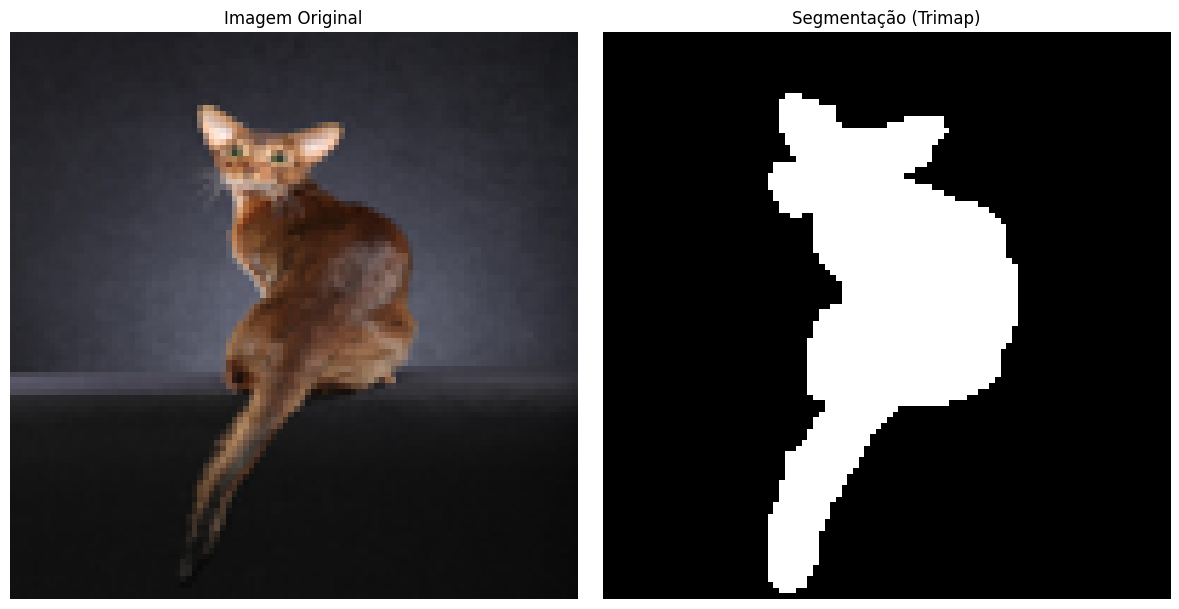

In [73]:
visualize_segmented_image(redimensioned_data, redimensioned_segmentation, 2)

# 3. Preprocessing

## 3.1. Transforming images into gray scale

In [74]:
def gray_transforming(images):
    """
    Tranforma base de imagens para tom de cinza.

    :param data: Array de imagens a serem preprocessadas.
    """
    
    gray_images = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images])

    return gray_images

def visualize_gray_image(data, num_images, title):
    """
    Exibe uma imagem e sua segmentação lado a lado.
    
    :param data: Array de imagens do Oxford-IIIT Pet Dataset.
    :param data_semented: Array de segmentações.
    :param num_images: número de imagens a serem exibidas
    """

    plt.figure(figsize=(15, 6))
    
    for i in range(num_images):    
        
        plt.subplot(1, num_images, i+1)
        plt.imshow(data[i], cmap='gray')
        plt.title(title)
        plt.axis("off")

    plt.show()
        

In [75]:
data_gray = gray_transforming(data) 
redimensioned_data_gray = gray_transforming(redimensioned_data)

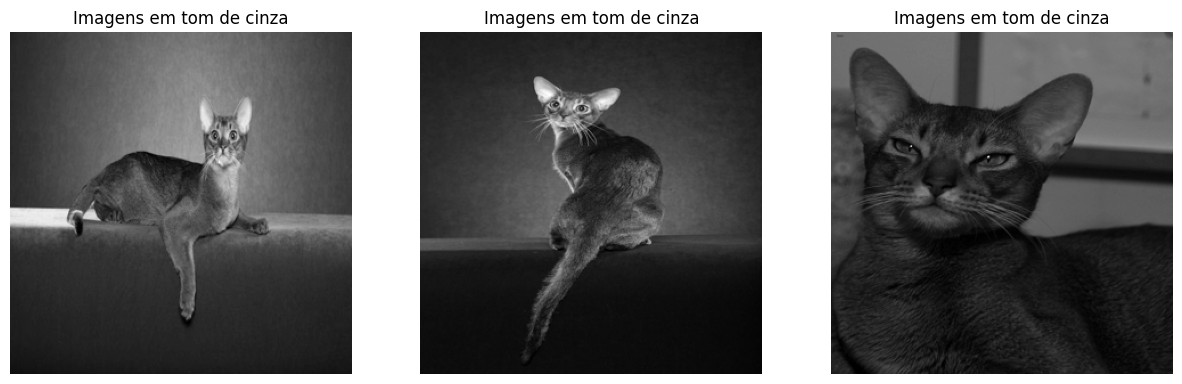

In [76]:
visualize_gray_image(data_gray, num_images=3, title="Imagens em tom de cinza")

## 3.2. Changing the color system

In [77]:
def color_system_change(images):
    """
    Transforma base de imagens para sistema de cor YUV.

    :param data: Array de imagens a serem preprocessadas.
    """

    system_change = []
    for img in images:

        # converte para YUV
        img_changed = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        system_change.append(img_changed)

    system_change = np.stack(system_change, axis=0)

    return system_change

In [78]:
data_color_system_change = color_system_change(data) 
data_color_system_change_gray = gray_transforming(data_color_system_change)

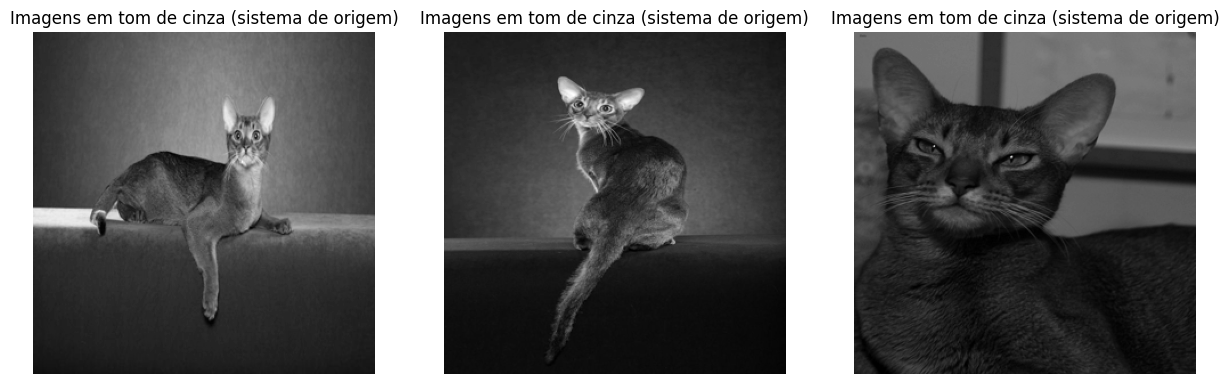

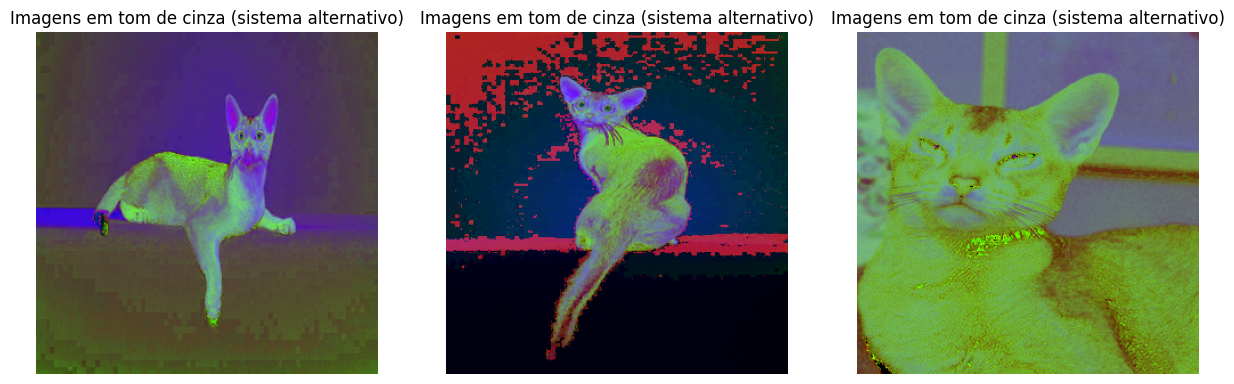

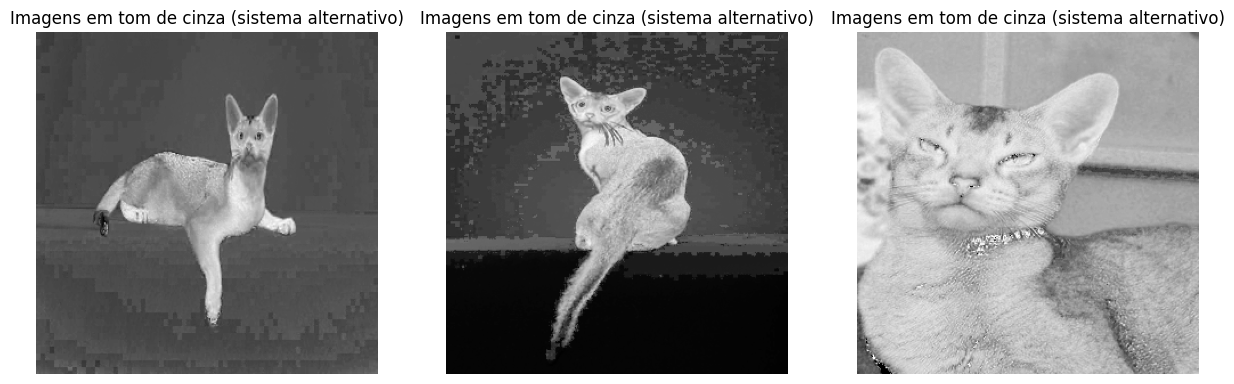

In [79]:
visualize_gray_image(data_gray, title="Imagens em tom de cinza (sistema de origem)", num_images=3)
visualize_gray_image(data_color_system_change, title="Imagens em tom de cinza (sistema alternativo)", num_images=3)
visualize_gray_image(data_color_system_change_gray, title="Imagens em tom de cinza (sistema alternativo)", num_images=3)

# 4. Developing strategy for image segmentation

## 4.1. Filtering + Tresholding + Erosation + Dilatation

Parâmetros:

1- Kernel para filtro passa alta \
2- Corte para binarizar \
3- Elemento estruturante para erosão \
4- Número de iterações na erosão \
5- Elemento estruturante para dilatação \
6- Número de iterações na dilatação 


Class definition:

In [80]:
class segmentation_strategy_one(BaseEstimator, ClassifierMixin):
    
    def __init__(self, filter_kernel=None, corte=None, erosion_kernel=None, dilatation_kernel=None,
             num_it_erosion=None, num_it_dilatation=None):
        
        if filter_kernel is None:
            filter_kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=np.float32)
        
        if erosion_kernel is None:
            erosion_kernel = np.ones((2, 2), np.uint8)
        
        if dilatation_kernel is None:
            dilatation_kernel = np.ones((4, 4), np.uint8)

        self.filter_kernel = filter_kernel
        self.corte = corte if corte is not None else 2
        self.erosion_kernel = erosion_kernel
        self.dilatation_kernel = dilatation_kernel
        self.num_it_erosion = num_it_erosion if num_it_erosion is not None else 1
        self.num_it_dilatation = num_it_dilatation if num_it_dilatation is not None else 2
        self.data_segmented = None # segmentação de referência
        self.segmentation = None # segmentação obtida


    def fit(self, X, y=None):
        """Segmenta as imagens usando a estratégia definida."""
        self.data_segmented = y
        data_segmented_strategy_one = []

        for image in X:
            # Filtro passa-alta
            img = cv2.filter2D(image, -1, self.filter_kernel)
            
            # Binarização
            corte_local = np.mean(img) + self.corte * np.std(img)
            _, img = cv2.threshold(img, corte_local, 255, cv2.THRESH_BINARY)
            
            # Erosão e dilatação
            img = cv2.erode(img, self.erosion_kernel, iterations=self.num_it_erosion)
            img = cv2.dilate(img, self.dilatation_kernel, iterations=self.num_it_dilatation)

            data_segmented_strategy_one.append(img)
        
        self.segmentation = np.stack(data_segmented_strategy_one, axis=0)
        return self

    def predict(self, X):
        """Segmenta as imagens de entrada X."""
        self.fit(X)
        return self.segmentation

    def accuracy(self, predicted_segmentation):
        """Calcula a acurácia entre a segmentação real e a predita."""
        if self.data_segmented is None:
            raise ValueError("Segmentação de referência não registrada.")

        predicted_segmentation = (predicted_segmentation / 255).astype(int)
        original_segmentation = self.data_segmented.astype(int)

        # Cálculo da acurácia
        n_samples, height, width = original_segmentation.shape
        correct_per_image = np.sum(original_segmentation == predicted_segmentation, axis=(1, 2))
        accuracy_per_image = (correct_per_image / (height * width)) * 100
        total_accuracy = (np.sum(correct_per_image) / (height * width * n_samples)) * 100

        return accuracy_per_image, total_accuracy

    def get_params(self, deep=True):
        """Obtém parâmetros para o GridSearchCV."""
        return {
            'filter_kernel': self.filter_kernel,
            'corte': self.corte,
            'erosion_kernel': self.erosion_kernel,
            'dilatation_kernel': self.dilatation_kernel,
            'num_it_erosion': self.num_it_erosion,
            'num_it_dilatation': self.num_it_dilatation
        }

    def set_params(self, **params):
        """Configura parâmetros para o GridSearchCV."""
        for key, value in params.items():
            setattr(self, key, value)
        return self

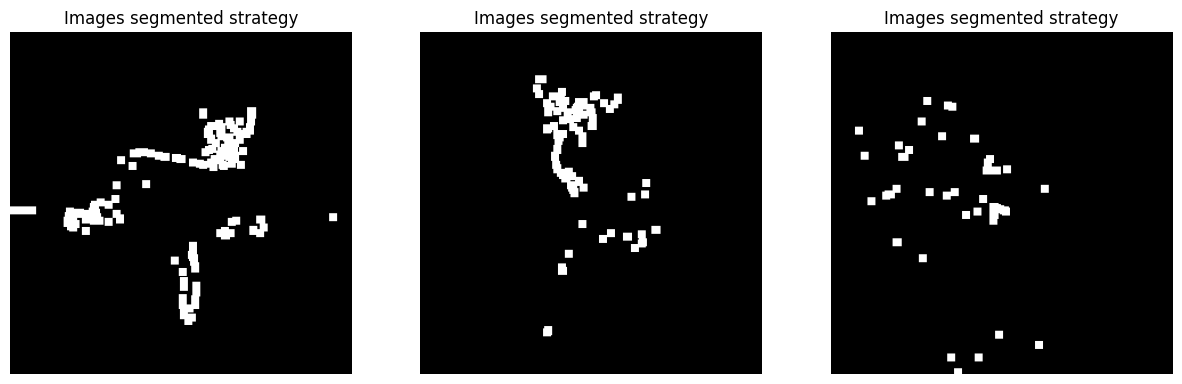

[87.08444444 83.86222222 29.92111111 57.66666667 64.80111111 30.32555556
 72.03444444 64.85777778 69.70444444 78.08555556 53.26555556 81.25222222
 37.95111111 80.37666667 66.40777778 80.85333333 46.01888889 27.55333333
 65.65666667 45.75444444 64.78666667 53.60333333 55.52       56.62
 69.50777778 26.35111111]
Acurácia média obtida: 59.61 %


In [81]:
model = segmentation_strategy_one()
model.fit(X=data_gray, y=data_segmented)
data_segmented_strategy_one = model.segmentation
visualize_gray_image(data_segmented_strategy_one, num_images=3, title="Images segmented strategy")
accuracy_per_image, accuracy = model.accuracy(data_segmented_strategy_one)
print(accuracy_per_image)
print(f"Acurácia média obtida: {accuracy:.2f} %")

## 4.2. Doing Gridsearch to determine best parameters

### Grid-search - data_gray

In [82]:
# # personalized score for Grid Search
# def custom_accuracy_scorer(model, X, y):
#     """
#     Função de pontuação personalizada para o GridSearchCV usando a acurácia.
#     """
#     data_segmented_strategy = model.fit(X,y)
#     result_segmented = model.segmentation
#     accuracy_per_image, accuracy = model.accuracy(result_segmented)
#     return accuracy  

# # Grid Search definition
# param_grid = {
#     'filter_kernel': [
#         np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=np.float32),
#         np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]], dtype=np.float32),
#         np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=np.float32),
#         np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=np.float32)
#     ],
#     'erosion_kernel': [
#         np.ones((1, 1), np.uint8),
#         np.ones((2, 2), np.uint8),
#         np.ones((3, 3), np.uint8),
#         np.array([[0, 0, 0], [0, 1, 0], [0, 1, 0]], dtype=np.uint8),
#         np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8),
#         np.array([[1, 1], [0, 0]], dtype=np.uint8)
#     ],
#     'dilatation_kernel': [
#         np.ones((3, 3), np.uint8),
#         np.ones((4, 4), np.uint8),
#         np.ones((5, 5), np.uint8),
#         np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
#     ],
#     'num_it_erosion': [1, 2, 5, 10, 15, 20],
#     'num_it_dilatation': [1, 2, 5, 10, 15, 20],
#     'corte': [1,2,5]
# }

# # Execução do Grid Search
# model = segmentation_strategy_one()
# grid_search_1 = GridSearchCV(
#     estimator=model, 
#     param_grid=param_grid, 
#     scoring=custom_accuracy_scorer, 
#     cv=3
# )

# grid_search_1.fit(data_gray, data_segmented)

# # Resultados
# print("Melhores parâmetros:", grid_search_1.best_params_)
# print("Melhor acurácia:", grid_search_1.best_score_)

Saving variable:

In [83]:
# with open('./variables/params_1.pkl', 'wb') as f:
#     pickle.dump(grid_search_1.best_params_, f)

### Testing results

Loading variable:

In [84]:
with open('./variables/params_1.pkl', 'rb') as f:
    params_1 = pickle.load(f)

print(params_1)

{'corte': 2, 'dilatation_kernel': array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8), 'erosion_kernel': array([[1]], dtype=uint8), 'filter_kernel': array([[-1., -1., -1.],
       [-1.,  8., -1.],
       [-1., -1., -1.]], dtype=float32), 'num_it_dilatation': 5, 'num_it_erosion': 1}


Normal data


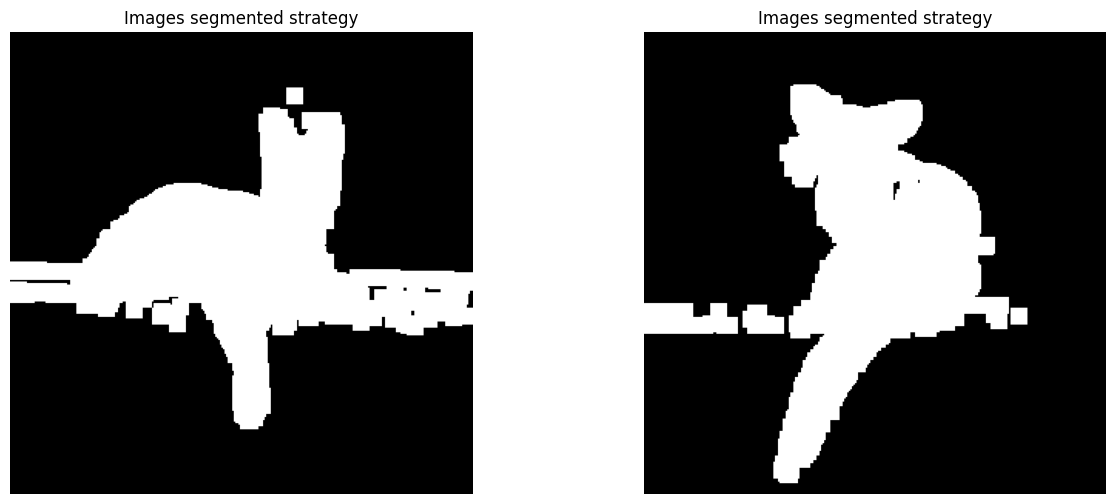

[92.48       95.60555556 85.23111111 78.89111111 96.49333333 76.37
 35.41333333 96.61444444 96.97666667 51.15222222 92.26333333 96.36333333
 68.24444444 80.67111111 96.47777778 90.28111111 64.27888889 66.80888889
 63.16       72.24444444 83.40555556 79.77555556 82.43444444 91.20333333
 94.48222222 58.85333333]
Acurácia média obtida: 80.24 %


In [85]:
dilatation_kernel = params_1['dilatation_kernel']
erosion_kernel = params_1['erosion_kernel']
filter_kernel = params_1['filter_kernel']
num_it_dilatation = params_1['num_it_dilatation']
num_it_erosion = params_1['num_it_erosion']
corte = params_1['corte']

print("Normal data")
best_model = segmentation_strategy_one(corte=corte, filter_kernel=filter_kernel,erosion_kernel=erosion_kernel,num_it_erosion=num_it_erosion,dilatation_kernel=dilatation_kernel,num_it_dilatation=num_it_dilatation)
best_model.fit(X=data_gray, y=data_segmented)
data_segmented_strategy_one_best_model = best_model.segmentation
visualize_gray_image(data_segmented_strategy_one_best_model, num_images=2, title="Images segmented strategy")
accuracy_per_image, accuracy = best_model.accuracy(data_segmented_strategy_one_best_model)
print(accuracy_per_image)
print(f"Acurácia média obtida: {accuracy:.2f} %")

### Viewing:

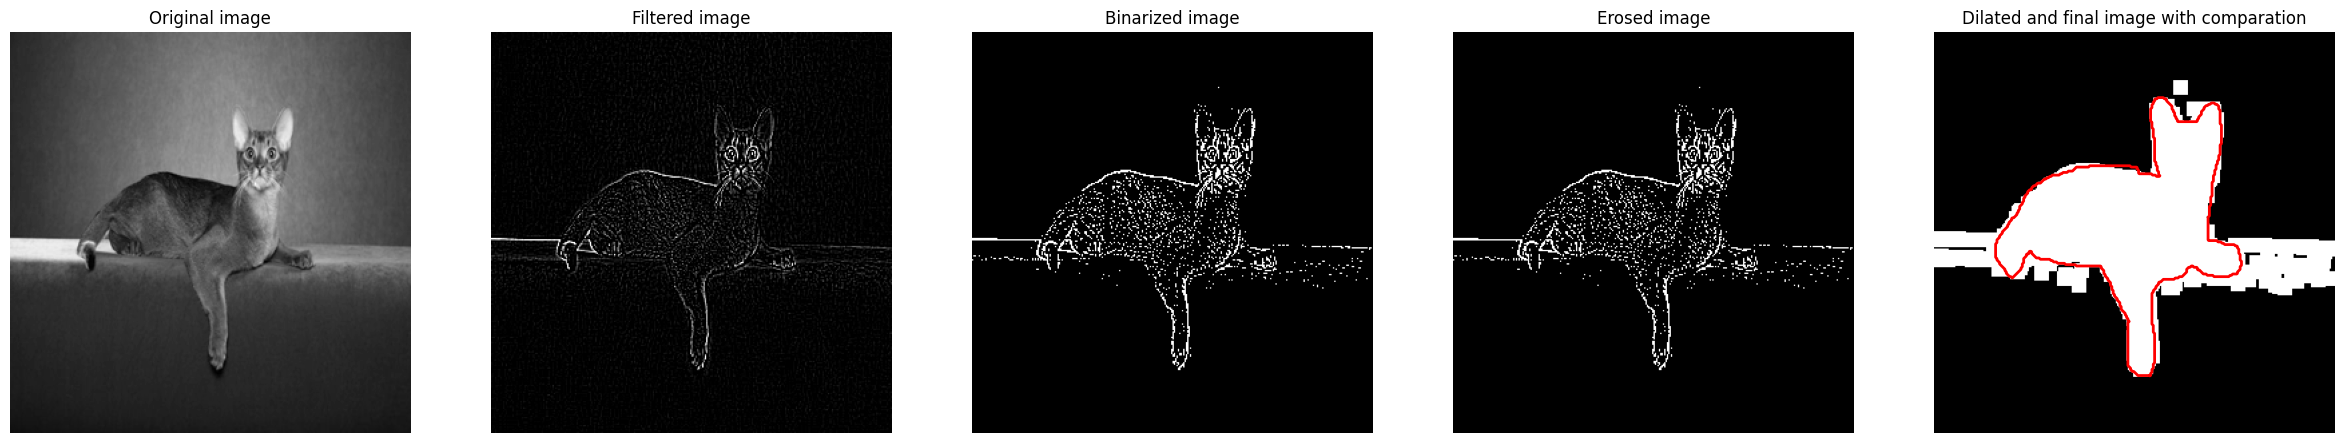

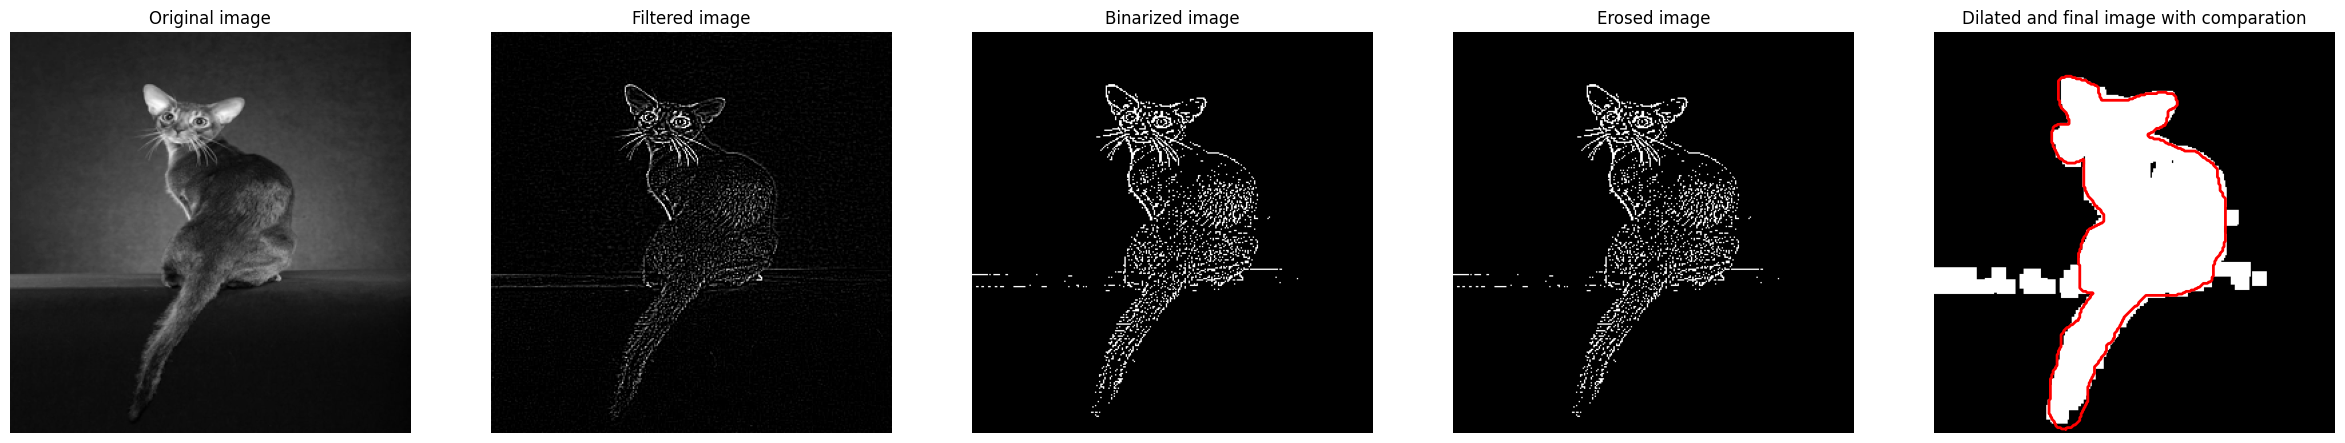

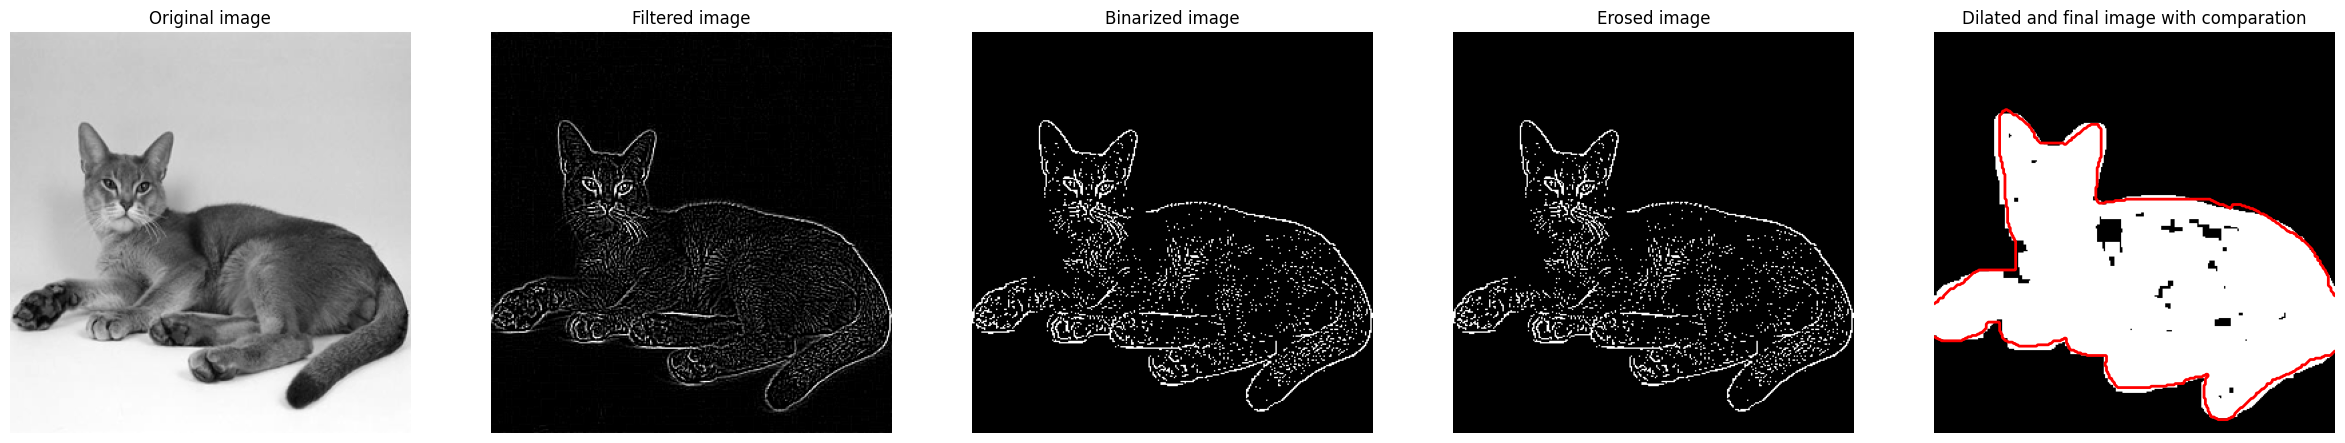

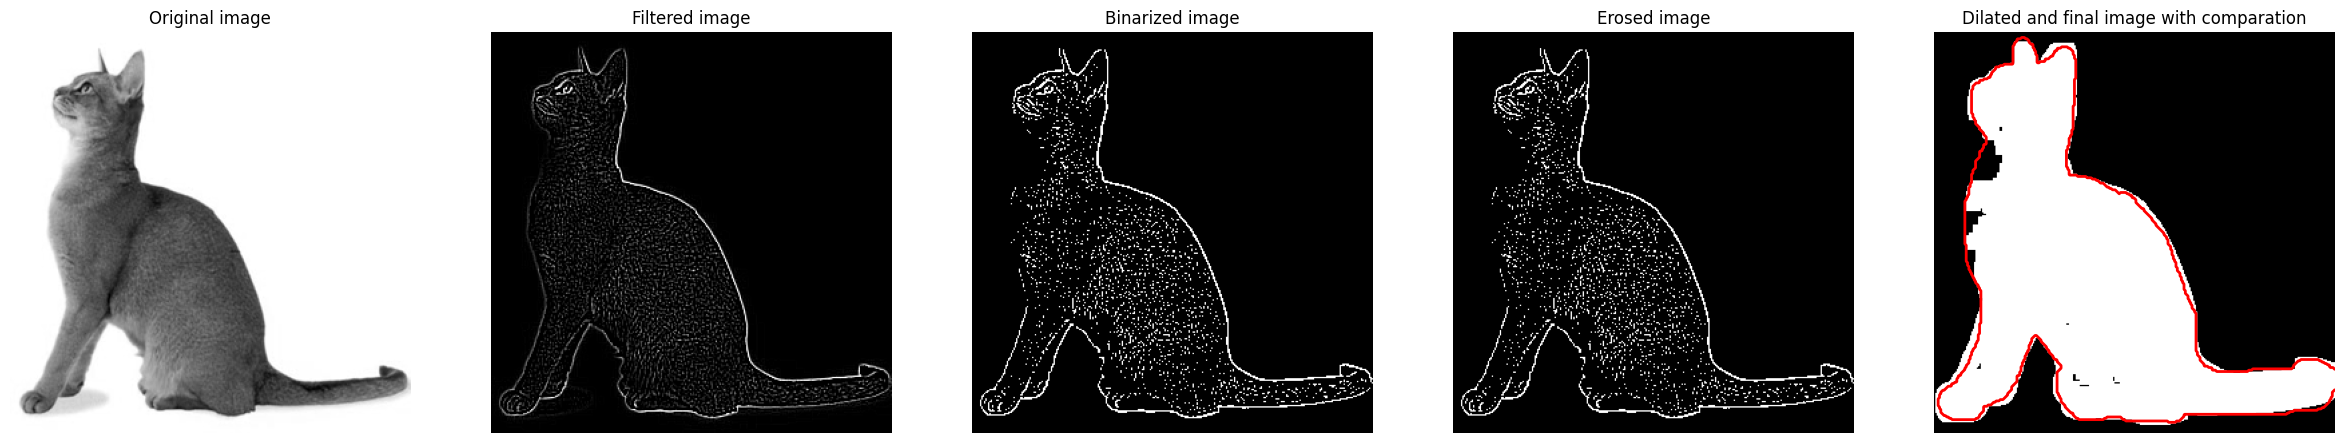

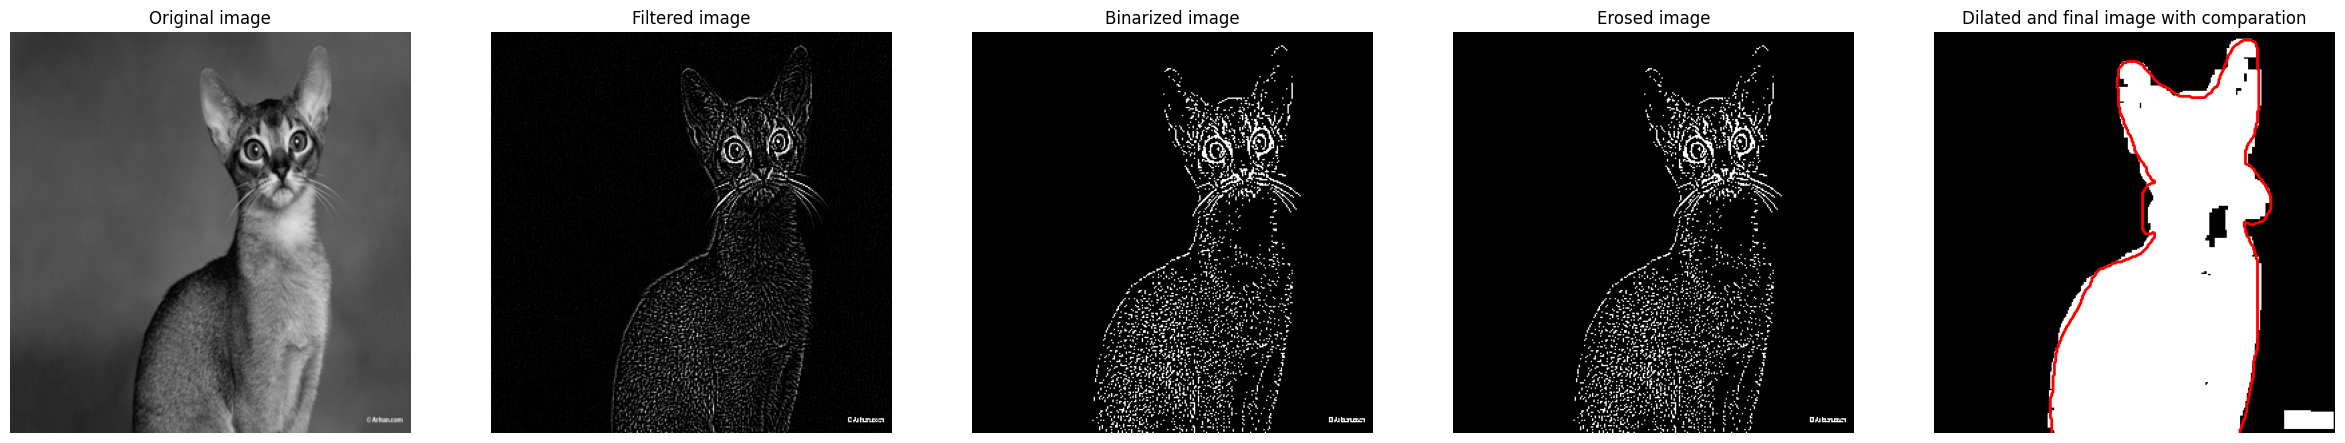

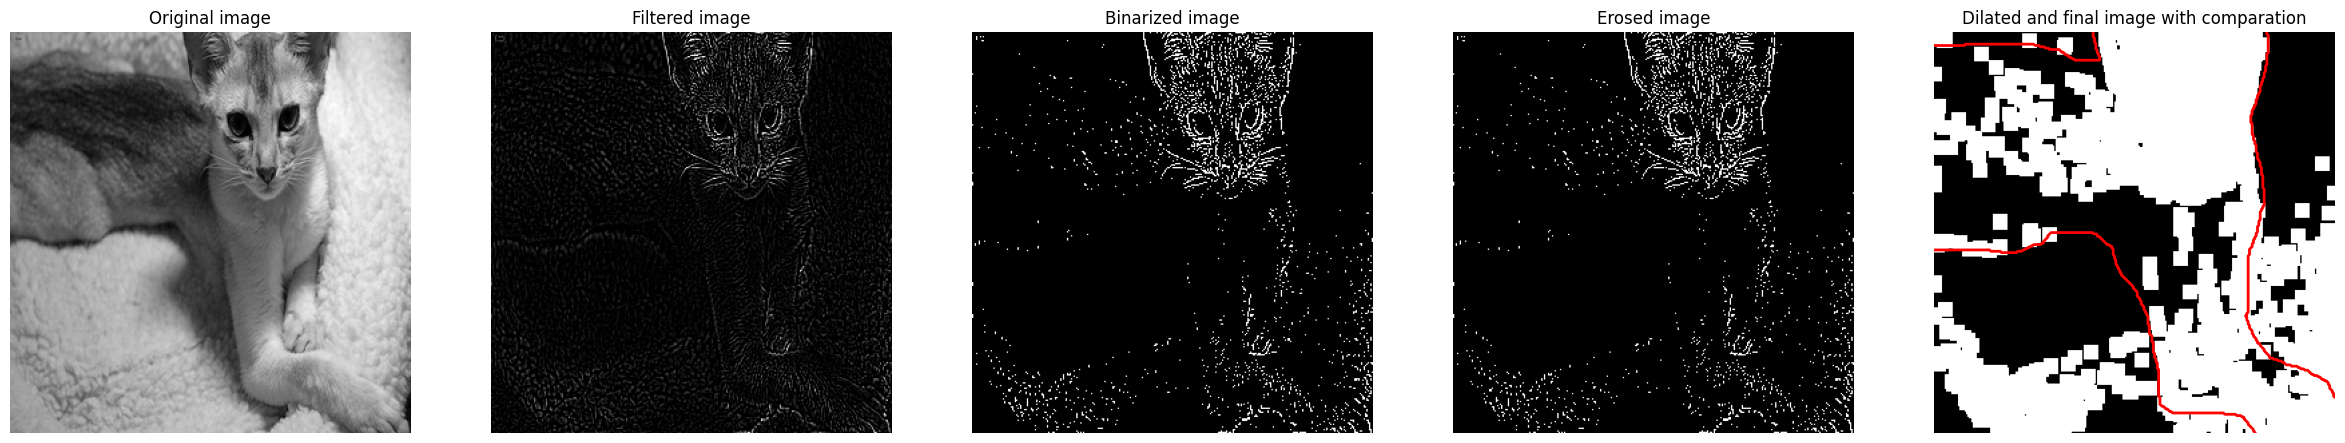

In [86]:
def viewing(img, title):
    plt.imshow(img, cmap='gray')        
    plt.title(title)
    plt.axis("off")

def viewing_edge_segmentation(image):
    contours = measure.find_contours(data_segmented[img], level=0.5)
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], color='red', linewidth=2)

# parameters
dilatation_kernel = params_1['dilatation_kernel']
erosion_kernel = params_1['erosion_kernel']
filter_kernel = params_1['filter_kernel']
num_it_dilatation = params_1['num_it_dilatation']
num_it_erosion = params_1['num_it_erosion']
corte - params_1['corte']

i = [0,1,4,7,8,16]

for img in i:
    plt.figure(figsize=(30, 10))

    image = data_gray[img]
    plt.subplot(1,5,1)
    viewing(image, "Original image")

    # Filtro passa-alta
    image = cv2.filter2D(image, -1, filter_kernel)
    plt.subplot(1,5,2)
    viewing(image, "Filtered image")
                
    # Binarização
    corte_local = np.mean(image) + corte * np.std(image)
    _, image = cv2.threshold(image, corte_local, 255, cv2.THRESH_BINARY)
    plt.subplot(1,5,3)
    viewing(image, "Binarized image")
                
    # Erosão e dilatação
    image = cv2.erode(image, erosion_kernel, iterations=num_it_erosion)
    plt.subplot(1,5,4)
    viewing(image, "Erosed image")

    image = cv2.dilate(image, dilatation_kernel, iterations=num_it_dilatation)

    # Final comparation
    plt.subplot(1,5,5)
    viewing(image, "Dilated and final image with comparation")
    viewing_edge_segmentation(data_segmented[img])

    plt.show()

### Grid search caso 2

In [87]:
# # personalized score for Grid Search
# def custom_accuracy_scorer(model, X, y):
#     """
#     Função de pontuação personalizada para o GridSearchCV usando a acurácia.
#     """
#     data_segmented_strategy = model.fit(X,y)
#     result_segmented = model.segmentation
#     accuracy_per_image, accuracy = model.accuracy(result_segmented)
#     return accuracy  

# # Configuração do Grid Search
# param_grid = {
#     'filter_kernel': [
#         np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=np.float32),
#         np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]], dtype=np.float32),
#         np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=np.float32),
#         np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=np.float32)
#     ],
#     'erosion_kernel': [
#         np.ones((1, 1), np.uint8),
#         np.ones((2, 2), np.uint8),
#         np.ones((3, 3), np.uint8),
#         np.array([[0, 0, 0], [0, 1, 0], [0, 1, 0]], dtype=np.uint8),
#         np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8),
#         np.array([[1, 1], [0, 0]], dtype=np.uint8)
#     ],
#     'dilatation_kernel': [
#         np.ones((3, 3), np.uint8),
#         np.ones((4, 4), np.uint8),
#         np.ones((5, 5), np.uint8),
#         np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
#     ],
#     'num_it_erosion': [1, 2, 5, 10, 15, 20],
#     'num_it_dilatation': [1, 2, 5, 10, 15, 20],
#     'corte': [1,2,5]
# }

# # Execução do Grid Search
# model = segmentation_strategy_one()
# grid_search_2 = GridSearchCV(
#     estimator=model, 
#     param_grid=param_grid, 
#     scoring=custom_accuracy_scorer, 
#     cv=3
# )

# grid_search_2.fit(data_color_system_change_gray, data_segmented)

# # Resultados
# print("Melhores parâmetros:", grid_search_2.best_params_)
# print("Melhor acurácia:", grid_search_2.best_score_)

Saving variable:

In [88]:
# with open('./variables/params_2.pkl', 'wb') as f:
#     pickle.dump(grid_search_2.best_params_, f)

### Testing result

Loading variable:

In [89]:
with open('./variables/params_2.pkl', 'rb') as f:
    params_2 = pickle.load(f)

print(params_2)

{'corte': 2, 'dilatation_kernel': array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1]], dtype=uint8), 'erosion_kernel': array([[1]], dtype=uint8), 'filter_kernel': array([[-1., -1., -1.],
       [-1.,  9., -1.],
       [-1., -1., -1.]], dtype=float32), 'num_it_dilatation': 5, 'num_it_erosion': 1}


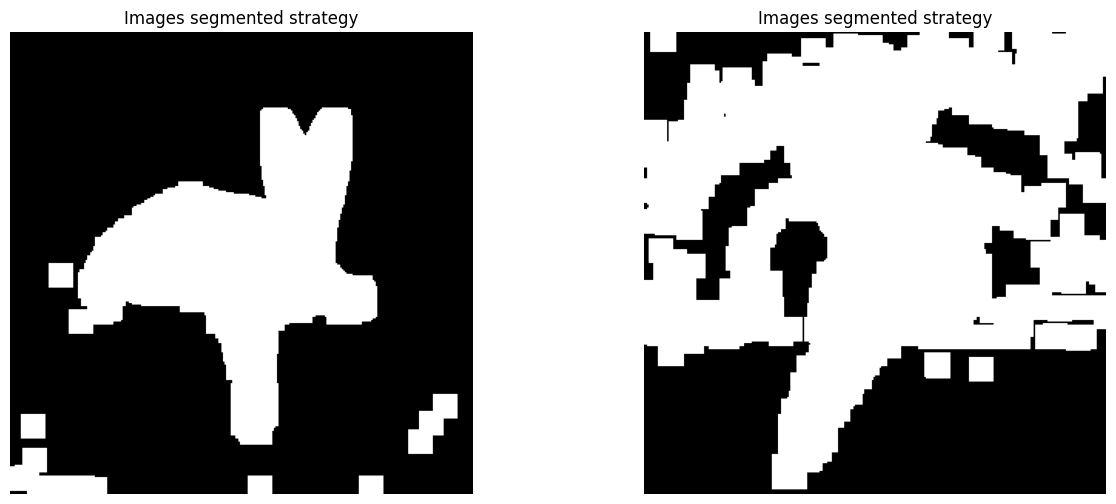

[92.25333333 59.01888889 86.82       39.76666667 89.03444444 79.71555556
 27.72333333 86.09666667 91.72888889 43.58555556 88.97333333 84.54222222
 39.94444444 62.01111111 87.26444444 40.18       72.85888889 40.42222222
 92.43777778 65.74444444 54.36       91.12888889 55.48888889 83.35888889
 63.70666667 66.28      ]
Acurácia média obtida: 68.63 %


In [90]:
dilatation_kernel = params_2['dilatation_kernel']
erosion_kernel = params_2['erosion_kernel']
filter_kernel = params_2['filter_kernel']
num_it_dilatation = params_2['num_it_dilatation']
num_it_erosion = params_2['num_it_erosion']
corte = params_2['corte']

best_model = segmentation_strategy_one(corte=corte, filter_kernel=filter_kernel,erosion_kernel=erosion_kernel,num_it_erosion=num_it_erosion,dilatation_kernel=dilatation_kernel,num_it_dilatation=num_it_dilatation)
best_model.fit(X=data_color_system_change_gray, y=data_segmented)
data_segmented_strategy_one_best_model_2 = best_model.segmentation
visualize_gray_image(data_segmented_strategy_one_best_model_2, num_images=2, title="Images segmented strategy")
accuracy_per_image, accuracy = best_model.accuracy(data_segmented_strategy_one_best_model_2)
print(accuracy_per_image)
print(f"Acurácia média obtida: {accuracy:.2f} %")

### Comparation:

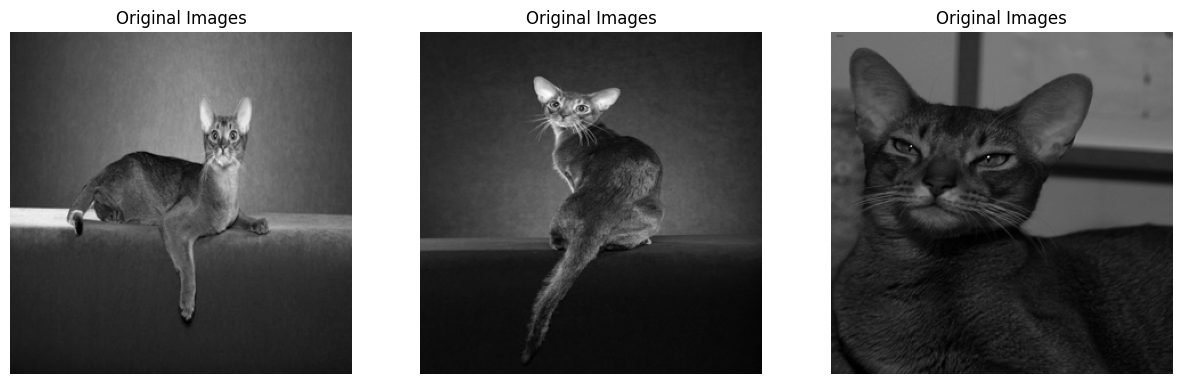

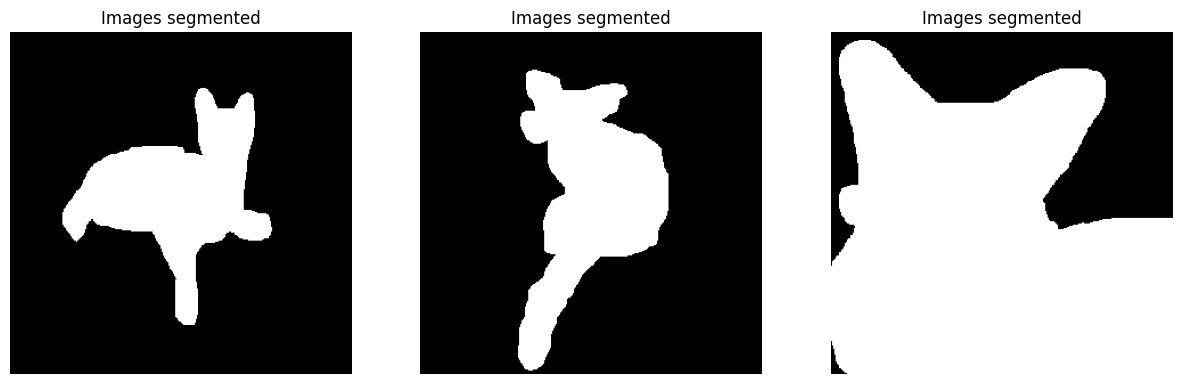

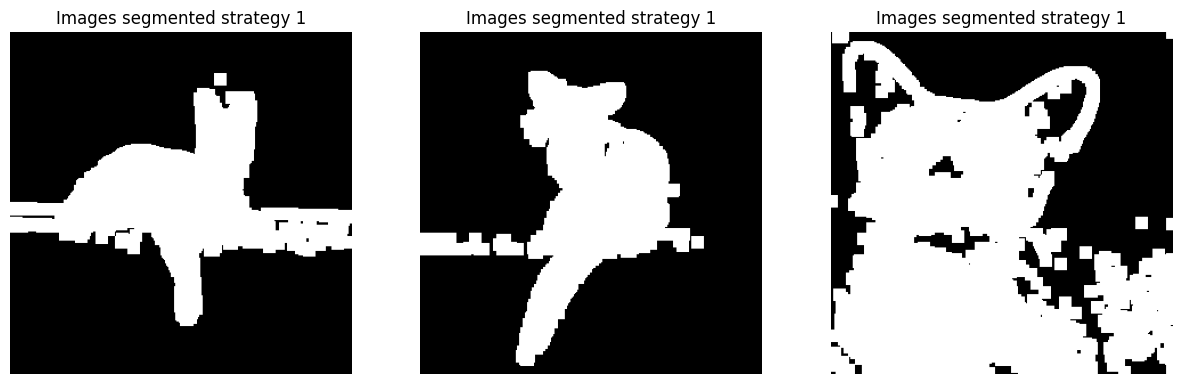

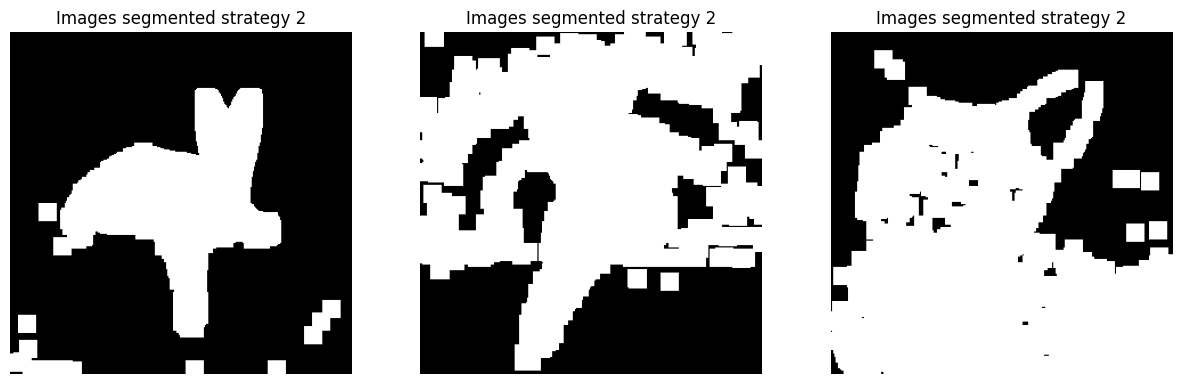

In [91]:
visualize_gray_image(data_gray, num_images=3, title="Original Images")
visualize_gray_image(data_segmented, num_images=3, title="Images segmented")
visualize_gray_image(data_segmented_strategy_one_best_model, num_images=3, title="Images segmented strategy 1")
visualize_gray_image(data_segmented_strategy_one_best_model_2, num_images=3, title="Images segmented strategy 2")

# 5. Grid Search for Redimensioned Data

## Searching:

In [95]:
img = 0

# personalized score for Grid Search
def custom_accuracy_scorer(model, X, y):
    """
    Função de pontuação personalizada para o GridSearchCV usando a acurácia.
    """
    data_segmented_strategy = model.fit(X,y)
    result_segmented = model.segmentation
    accuracy_per_image, accuracy = model.accuracy(result_segmented)
    return accuracy  

# Grid Search definition
param_grid = {
    'filter_kernel': [
        np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=np.float32),
        np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]], dtype=np.float32),
        np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=np.float32),
        np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=np.float32)
    ],
    'erosion_kernel': [
        np.ones((1, 1), np.uint8),
        np.ones((2, 2), np.uint8),
        np.ones((3, 3), np.uint8),
        np.array([[0, 0, 0], [0, 1, 0], [0, 1, 0]], dtype=np.uint8),
        np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8),
        np.array([[1, 1], [0, 0]], dtype=np.uint8)
    ],
    'dilatation_kernel': [
        np.ones((3, 3), np.uint8),
        np.ones((4, 4), np.uint8),
        np.ones((5, 5), np.uint8),
        np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
    ],
    'num_it_erosion': [1, 2, 5, 10, 15, 20],
    'num_it_dilatation': [1, 2, 5, 10, 15, 20],
    'corte': [1,2,5]
}

# Execução do Grid Search
model = segmentation_strategy_one()
grid_search_4 = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring=custom_accuracy_scorer, 
    cv= 3
)

grid_search_4.fit(redimensioned_data_gray, redimensioned_segmentation)

# Resultados
print("Melhores parâmetros:", grid_search_4.best_params_)
print("Melhor acurácia:", grid_search_4.best_score_)

Melhores parâmetros: {'corte': 1, 'dilatation_kernel': array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8), 'erosion_kernel': array([[1]], dtype=uint8), 'filter_kernel': array([[ 0., -1.,  0.],
       [-1.,  4., -1.],
       [ 0., -1.,  0.]], dtype=float32), 'num_it_dilatation': 2, 'num_it_erosion': 1}
Melhor acurácia: 77.29597222222223


In [96]:
with open('./variables/params_4.pkl', 'wb') as f:
    pickle.dump(grid_search_4.best_params_, f)

## Results:

{'corte': 1, 'dilatation_kernel': array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8), 'erosion_kernel': array([[1]], dtype=uint8), 'filter_kernel': array([[ 0., -1.,  0.],
       [-1.,  4., -1.],
       [ 0., -1.,  0.]], dtype=float32), 'num_it_dilatation': 2, 'num_it_erosion': 1}


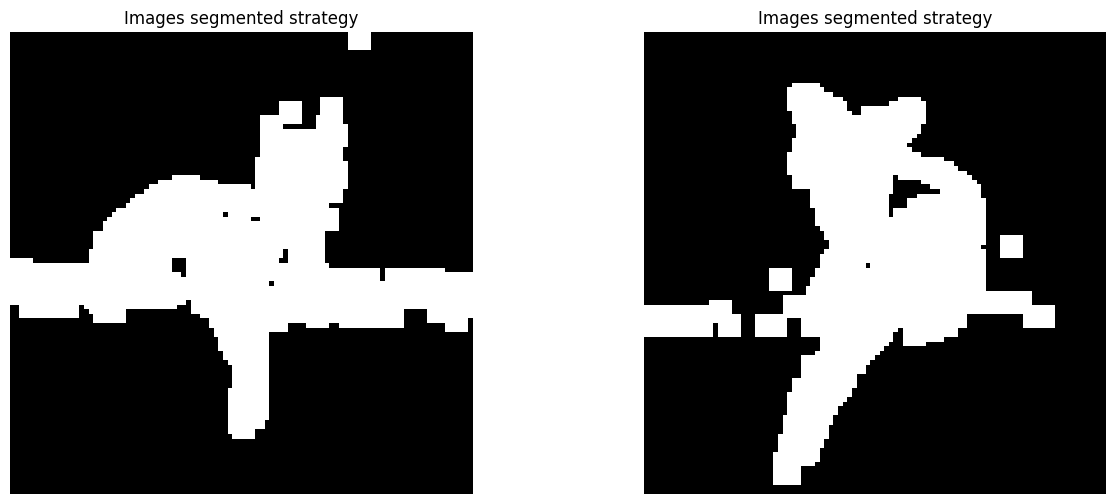

[90.83 93.23 75.43 78.97 88.51 74.86 40.41 84.19 95.53 57.01 84.23 96.14
 49.17 68.48 95.07 90.03 63.28 70.41 73.58 72.2  84.92 80.09 56.25 81.35
 92.19 73.83]
Acurácia média obtida: 77.31 %


In [97]:
with open('./variables/params_4.pkl', 'rb') as f:
    params_4 = pickle.load(f)

print(params_4)

dilatation_kernel = params_4['dilatation_kernel']
erosion_kernel = params_4['erosion_kernel']
filter_kernel = params_4['filter_ke rnel']
num_it_dilatation = params_4['num_it_dilatation']
num_it_erosion = params_4['num_it_erosion']
corte = params_4['corte']

best_model = segmentation_strategy_one(filter_kernel=filter_kernel, corte=corte, erosion_kernel=erosion_kernel,num_it_erosion=num_it_erosion,dilatation_kernel=dilatation_kernel,num_it_dilatation=num_it_dilatation)
best_model.fit(X=redimensioned_data_gray, y=redimensioned_segmentation)
redimensioned_data_segmented_strategy_one_best_model = best_model.segmentation
visualize_gray_image(redimensioned_data_segmented_strategy_one_best_model, num_images=2, title="Images segmented strategy")
accuracy_per_image, accuracy = best_model.accuracy(redimensioned_data_segmented_strategy_one_best_model)
print(accuracy_per_image)
print(f"Acurácia média obtida: {accuracy:.2f} %")

# 6. Incremeting strategy

## 6.1 Aplying the low pass before the dilatation